In [149]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [150]:

# La API de Our World in Data requiere que nos identifiquemos.
# Esto es para que el servidor sepa quién está descargando.
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}
# URL template: the {} will be replaced by the chart's short name (slug).
BASE_URL = "https://ourworldindata.org/grapher/{}.csv?v=1&csvType=full&useColumnShortNames=true"

# Dictionary of the 6 datasets
DATASETS = {
    "accumulated_waste": "plastic-waste-accumulated-in-oceans",
    "microplastics_global": "microplastics-in-ocean",
    "sea_temp_anomaly": "sea-surface-temperature-anomaly",
    "production_projections": "global-plastic-production-projections",
    "production_historical": "global-plastics-production",
    "emitted_share": "share-of-global-plastic-waste-emitted-to-the-ocean"
}

Accumulated Waste in Europe 

In [151]:
# Indicate which dataset to download
dataset_name = "accumulated_waste"
slug = DATASETS[dataset_name]  # this gives "plastic-waste-accumulated-in-oceans"

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_accumulated_waste = pd.read_csv(url, storage_options=USER_AGENT)


In [152]:
df_accumulated_waste.shape 

(200, 4)

In [153]:
df_accumulated_waste.columns.tolist()

['Entity', 'Code', 'Year', 'value__leakage_type_accumulated_stock_in_oceans']

In [154]:
df_accumulated_waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Entity                                           200 non-null    object 
 1   Code                                             80 non-null     object 
 2   Year                                             200 non-null    int64  
 3   value__leakage_type_accumulated_stock_in_oceans  200 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.4+ KB


In [155]:
# Delete 'Code' column 
if 'Code' in df_accumulated_waste.columns:
    df_accumulated_waste = df_accumulated_waste.drop(columns=['Code'])
    
# Rename columns for clarity
df_accumulated_waste = df_accumulated_waste.rename(columns={
    'value__leakage_type_accumulated_stock_in_oceans': 'accumulated_mtonnes',
})
# Standardize column names
df_accumulated_waste.columns = df_accumulated_waste.columns.str.lower().str.replace(' ', '_', regex=False)

#Delete "world" of entity column
df_accumulated_waste = df_accumulated_waste.loc[df_accumulated_waste['entity'] != 'World'].copy()

# Transform the total accumulated waste from tonnes to million tonnes
df_accumulated_waste['accumulated_million_tonnes'] = df_accumulated_waste['accumulated_mtonnes'] / 1_000_000

In [156]:
df_accumulated_waste.columns.tolist()

['entity', 'year', 'accumulated_mtonnes', 'accumulated_million_tonnes']

In [157]:
sorted(df_accumulated_waste['entity'].unique())

['Americas (excl. USA)',
 'Asia (excl. China and India)',
 'China',
 'Europe',
 'India',
 'Middle East & North Africa',
 'Oceania',
 'Sub-Saharan Africa',
 'United States']

In [185]:
# EU info
df_europa = df_accumulated_waste[df_accumulated_waste['entity'] == 'Europe']

# Info for all entitys without EU
df_resto = df_accumulated_waste[df_accumulated_waste['entity'] != 'Europe']

# SUM all entitys without EU
df_resto_agregado = df_resto.groupby('year')['accumulated_million_tonnes'].sum().reset_index()
df_resto_agregado.rename(columns={'accumulated_million_tonnes': 'rest_of_world_million_tonnes'}, inplace=True)

# Union of EU with the rest
df_comparativa = df_europa[['year', 'accumulated_million_tonnes']].rename(
    columns={'accumulated_million_tonnes': 'europe_million_tonnes'}
).merge(df_resto_agregado, on='year', how='outer').sort_values('year').reset_index(drop=True)

# Optional: EU production
df_comparativa['total'] = df_comparativa['europe_million_tonnes'] + df_comparativa['rest_of_world_million_tonnes']
df_comparativa['europe_share_pct'] = (df_comparativa['europe_million_tonnes'] / df_comparativa['total']) * 100

# Mostrar la tabla completa
print("\n Anual comparation: EU vs. Rest of the world (M. tonnes)")
print(" ")
print(df_comparativa.to_string(index=False, float_format="%.2f"))


 Anual comparation: EU vs. Rest of the world (M. tonnes)
 
 year  europe_million_tonnes  rest_of_world_million_tonnes  total  europe_share_pct
 2000                   2.11                          6.36   8.47             24.89
 2001                   2.24                          6.92   9.15             24.43
 2002                   2.37                          7.51   9.88             23.98
 2003                   2.51                          8.15  10.66             23.51
 2004                   2.65                          8.84  11.48             23.04
 2005                   2.79                          9.57  12.36             22.58
 2006                   2.94                         10.35  13.29             22.11
 2007                   3.09                         11.18  14.27             21.64
 2008                   3.24                         12.06  15.30             21.18
 2009                   3.40                         12.99  16.39             20.73
 2010           

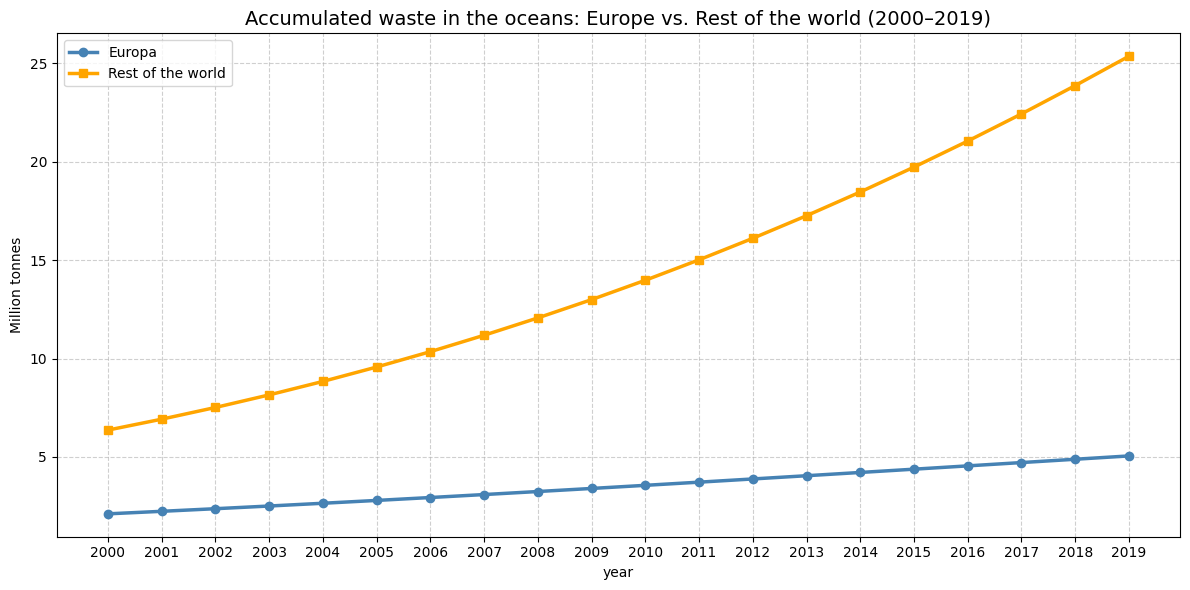

In [186]:
import matplotlib.pyplot as plt

# Year int
df_comparativa['year'] = df_comparativa['year'].astype(int)

plt.figure(figsize=(12, 6))
plt.plot(df_comparativa['year'], df_comparativa['europe_million_tonnes'],
         marker='o', linewidth=2.5, label='Europa', color='steelblue')
plt.plot(df_comparativa['year'], df_comparativa['rest_of_world_million_tonnes'],
         marker='s', linewidth=2.5, label='Rest of the world', color='orange')

plt.title('Accumulated waste in the oceans: Europe vs. Rest of the world (2000–2019)', fontsize=14)
plt.xlabel('year')
plt.ylabel('Million tonnes')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_comparativa['year'])  # Evita decimales
plt.tight_layout()
plt.show()

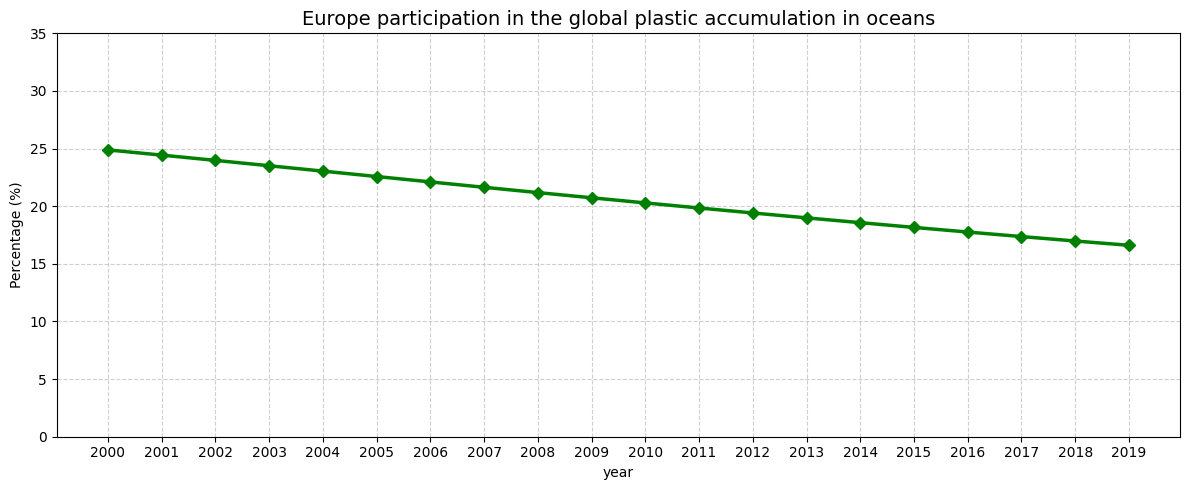

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_comparativa['year'], df_comparativa['europe_share_pct'],
         marker='D', linewidth=2.5, color='green')

plt.title('Europe participation in the global plastic accumulation in oceans', fontsize=14)
plt.xlabel('year')
plt.ylabel('Percentage (%)')
plt.ylim(0, 35)  
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_comparativa['year'])
plt.tight_layout()
plt.show()

Between 2000 and 2019, Europe's share of global plastic accumulation in the oceans fell from 25% to 16.5%, a reduction of 34% from its initial level. This steady trend reveals a structural shift in the geography of plastic pollution: while Europe is reducing its relative footprint, other continents (especially Asia and the Americas) are taking on increasing responsibility for the marine crisis. 

Key implications:
Not an absolute success:
The decline in share does not mean that Europe has reduced its absolute pollution; it may have increased, but at a slower rate than the rest of the world.

The problem is globalising and shifting:
The plastic crisis is no longer a ‘Western problem’; it is being driven by developing regions with inadequate waste management systems and rapidly growing consumption.

Opportunity for international cooperation:
Europe can become a key player in transferring technology, policies and funding to regions with the largest current contribution, accelerating global solutions.

SP:
Entre 2000 y 2019, la participación de Europa en la acumulación global de plástico en los océanos cayó de un 25% a un 16.5%, una reducción del 34% respecto a su nivel inicial. Esta tendencia constante revela un cambio estructural en la geografía de la contaminación plástica: mientras Europa reduce su huella relativa, otros continentes (especialmente Asia y América) están asumiendo una responsabilidad creciente en la crisis marina. 

Implicaciones clave:
No es un éxito absoluto:
La caída en la participación no implica que Europa haya reducido su contaminación absoluta, podría haber aumentado, pero a un ritmo menor que el resto del mundo.

El problema se globaliza y se desplaza:
La crisis plástica ya no es un “problema occidental”,  está siendo impulsada por regiones en desarrollo con sistemas de gestión de residuos insuficientes y un consumo en rápido crecimiento.

Oportunidad para cooperación internacional:
Europa puede convertirse en un actor clave para transferir tecnología, políticas y financiamiento a regiones con mayor contribución actual, acelerando soluciones globales.

In [161]:
! pip install matplotlib

import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\cmoan\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [187]:
#Filter only the last year (usually 2019)
last_year = df_accumulated_waste['year'].max()
df_last_year = df_accumulated_waste[df_accumulated_waste['year'] == last_year].copy()

# Sort from highest to lowest pollution
df_last_year = df_last_year[['entity', 'accumulated_million_tonnes']].sort_values(
    'accumulated_million_tonnes', ascending=False
).reset_index(drop=True)
df_last_year.sort_values('accumulated_million_tonnes', ascending=False)
print(f"\n Comparate all continents in {last_year}:")
print(" ")
print(df_last_year.to_string(index=False, float_format="%.2f"))


 Comparate all continents in 2019:
 
                      entity  accumulated_million_tonnes
Asia (excl. China and India)                        7.82
                      Europe                        5.05
        Americas (excl. USA)                        4.21
                       China                        3.90
               United States                        3.35
          Sub-Saharan Africa                        2.98
  Middle East & North Africa                        1.84
                       India                        1.22
                     Oceania                        0.03


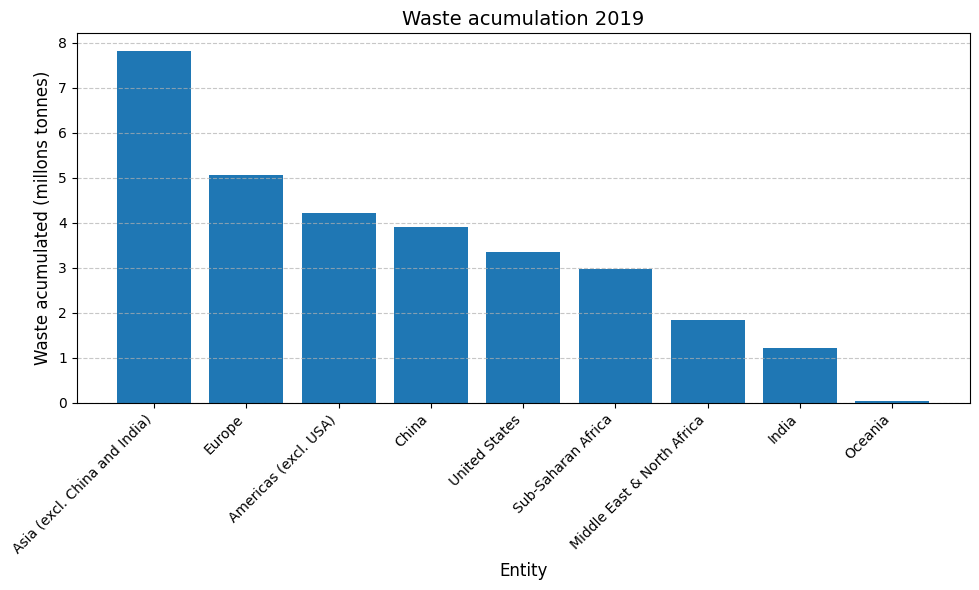

In [188]:

# Filter only the last year
last_year = df_accumulated_waste['year'].max()
df_last_year = df_accumulated_waste[df_accumulated_waste['year'] == last_year].copy()

# Sort from highest to lowest pollution
df_last_year = df_last_year[['entity', 'accumulated_million_tonnes']].sort_values(
    'accumulated_million_tonnes', ascending=False
).reset_index(drop=True)


# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(
    df_last_year['entity'],
    df_last_year['accumulated_million_tonnes'],
)

# Tags and title
plt.title(f'Waste acumulation {last_year}', fontsize=14)
plt.xlabel('Entity', fontsize=12)
plt.ylabel('Waste acumulated (millons tonnes)', fontsize=12)

# Rotate labels if they are long
plt.xticks(rotation=45, ha='right')

# Show grid and adjust layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#Show grafic
plt.show()


DF2: Microplásticos Globales

In [192]:
# Use the same USER_AGENT for all requests
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}

# Indicate which dataset to download
dataset_name = "microplastics_global"
slug = DATASETS[dataset_name]  # this gives "microplastics-in-ocean"

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_microplastics_global = pd.read_csv(url, storage_options=USER_AGENT)

In [193]:
df_microplastics_global.shape

(303, 4)

In [194]:
df_microplastics_global.columns.tolist()

['Entity', 'Code', 'Year', 'Accumulated ocean plastic: Microplastics (<0.5cm)']

In [195]:
df_microplastics_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 4 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Entity                                             303 non-null    object 
 1   Code                                               0 non-null      float64
 2   Year                                               303 non-null    int64  
 3   Accumulated ocean plastic: Microplastics (<0.5cm)  303 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 9.6+ KB


In [196]:
# see what is in the column for accumulated microplastics in the years 2000-2019
df_microplastics_global[
    (df_microplastics_global['Year'] >= 2000) & (df_microplastics_global['Year'] <= 2019)
][['Year', 'Accumulated ocean plastic: Microplastics (<0.5cm)']].sort_values('Year')

,Year,Accumulated ocean plastic: Microplastics (<0.5cm)
50,2000,154500
151,2000,154500
252,2000,154500
152,2001,166900
253,2001,166900
51,2001,166900
52,2002,180100
153,2002,180100
254,2002,180100
255,2003,194100


NOTE : The acumulated plastic is in tonnes

In [183]:
# Delete 'Code' column 
if 'Code' in df_microplastics_global.columns:
    df_microplastics_global = df_microplastics_global.drop(columns=['Code'])
# Rename columns for clarity
df_microplastics_global = df_microplastics_global.rename(columns={
    'accumulated_ocean_plastic:_microplastics_(<0.5cm)': 'microplastics_mtonnes'
})
# Standardize column names
df_microplastics_global.columns = df_microplastics_global.columns.str.lower().str.replace(' ', '_', regex=False)

# See the type of years column
df_microplastics_global['year'].dtype

dtype('int64')

In [184]:
# convert tonnes to million tonnes
df_microplastics_global['microplastics_million_tonnes'] = df_microplastics_global['microplastics_mtonnes'] / 1_000_000
print("Value in 2019 (toneladas):", df_microplastics_global[df_microplastics_global['year'] == 2019]['microplastics_mtonnes'].values[0])
print("Value in 2019 (millones):", df_microplastics_global[df_microplastics_global['year'] == 2019]['microplastics_million_tonnes'].values[0])

Value in 2019 (toneladas): 560200
Value in 2019 (millones): 0.5602


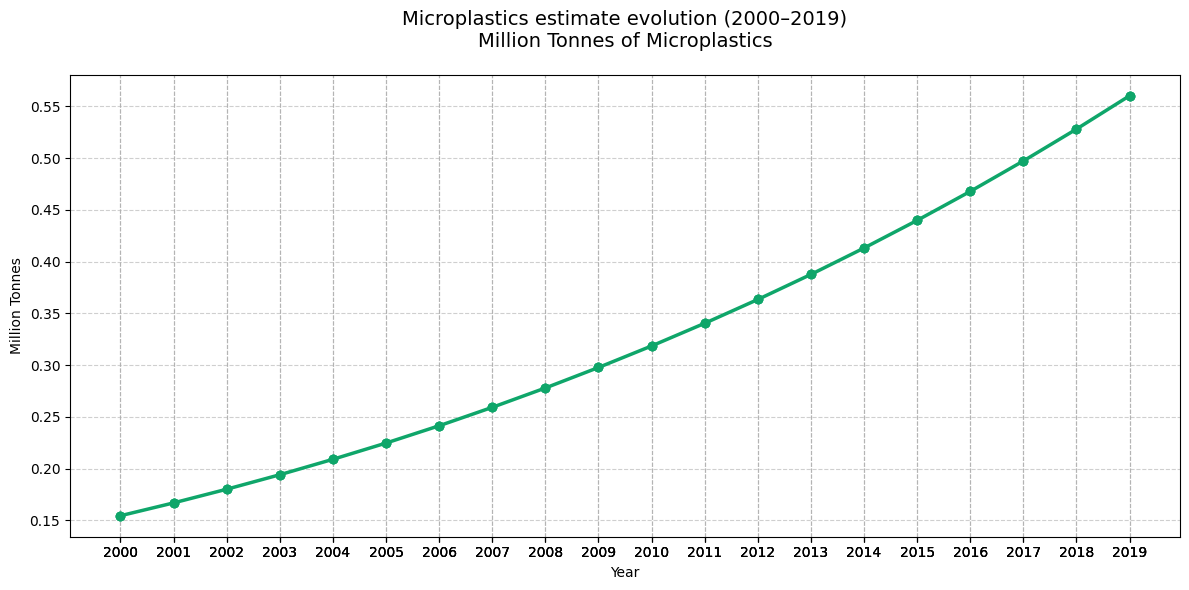

In [ ]:

#Sort data by year
df_plot = df_microplastics_global[
    (df_microplastics_global['year'] >= 2000) & (df_microplastics_global['year'] <= 2019)
].sort_values('year')

# Convert year to integer if necessary
df_plot['year'] = df_plot['year'].astype('Int64')

plt.figure(figsize=(12, 6))
plt.plot(df_plot['year'], df_plot['microplastics_million_tonnes'], 
         marker='o', linewidth=2.5, color="#0fa66a")

plt.title('Microplastics estimate evolution (2000–2019)\n'
          'Million Tonnes of Microplastics', fontsize=14, pad=20)
plt.xlabel('Year')
plt.ylabel('Million Tonnes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(df_plot['year'].astype(int)) 
plt.tight_layout()
plt.show()


The estimated mass of microplastics on the ocean surface has increased from < 20,000 tonnes in 2000 to over 500,000 tonnes in 2019, a more than 25-fold increase in nearly 40 years.

ES>> La masa estimada de microplásticos en la superficie de los océanos ha pasado de < 20,000 toneladas en 2000 a más de 500,000 toneladas en 2019, un aumento de más de 25 veces en casi 40 años.

In [ ]:
# Filter and order
df_micro = df_microplastics_global[
    (df_microplastics_global['year'] >= 2000) & 
    (df_microplastics_global['year'] <= 2019)
].sort_values('year').copy()

# Convert year to integer (avoid decimals)
df_micro = df_micro.dropna(subset=['year'])
df_micro['year'] = df_micro['year'].astype(int)

In [197]:
# Value in 2000 (base = 100%
valor_2000 = df_micro[df_micro['year'] == 2000]['microplastics_mtonnes'].values[0]

# Calculate relative index: 2000 = 100%, remainder = % increase
df_micro['increase_pct'] = (df_micro['microplastics_mtonnes'] / valor_2000) * 100

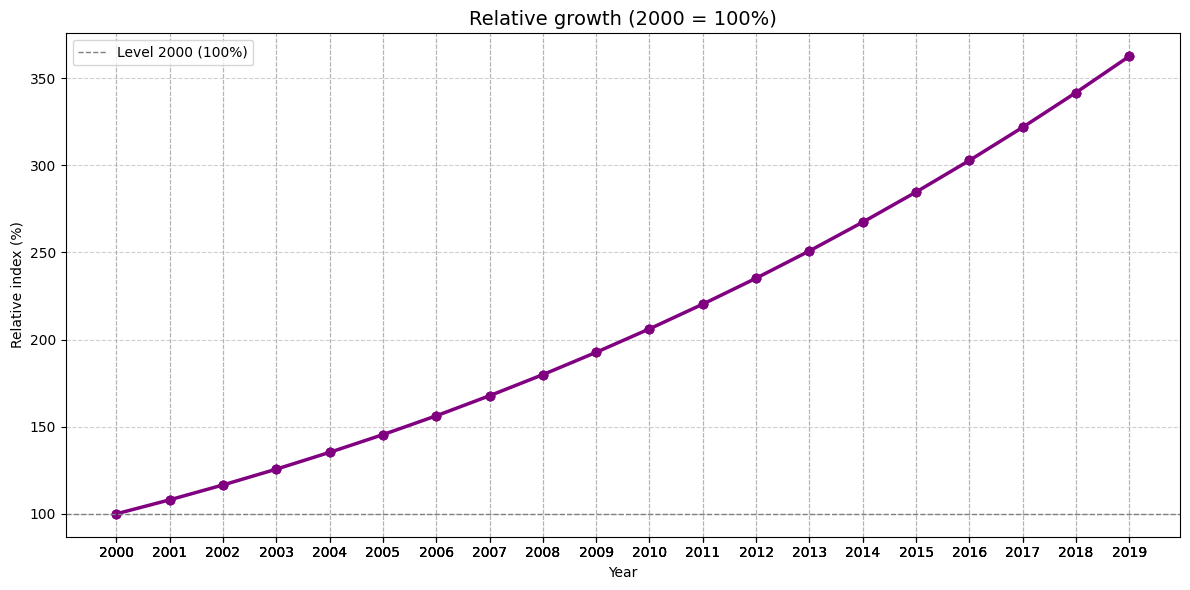

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(df_micro['year'], df_micro['increase_pct'], 
         marker='o', linewidth=2.5, color='purple')

plt.title('Relative growth (2000 = 100%)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Relative index (%)')
plt.axhline(100, color='gray', linestyle='--', linewidth=1, label='Level 2000 (100%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_micro['year'][::2]) 
plt.legend()
plt.tight_layout()
plt.xticks(df_micro['year'].astype(int)) 
plt.show()

Between 2000 and 2019, the mass of microplastics on the ocean surface increased from ~154,500 tonnes to ~560,200 tonnes. This represents a 262% increase in just 19 years, equivalent to tripling the microplastic load in less than two decades.

ES>>> Entre 2000 y 2019, la masa de microplásticos en la superficie de los océanos aumentó de ~154,500 toneladas a ~560,200 toneladas. Esto representa un aumento del 262% en solo 19 años, lo que equivale a triplicar la carga de microplásticos en menos de dos décadas

In [ ]:
# Total global
df_global_waste = df_accumulated_waste[
    df_accumulated_waste['entity'] != 'World'  
].groupby('year')['accumulated_million_tonnes'].sum().reset_index()
df_global_waste.rename(columns={'accumulated_million_tonnes': 'global_waste_mtonnes'}, inplace=True)

In [ ]:

df_micro_filtered = df_micro[['year', 'microplastics_mtonnes']].copy()
df_micro_filtered.rename(columns={'microplastics_mtonnes': 'microplastics_mtonnes'}, inplace=True)

In [ ]:
#  (2000-2019)
df_global_waste_clean = df_global_waste[
    (df_global_waste['year'] >= 2000) & (df_global_waste['year'] <= 2019)
].copy()

df_micro_clean = df_micro[
    (df_micro['year'] >= 2000) & (df_micro['year'] <= 2019)
].copy()

# Merge by year
df_combined = pd.merge(df_global_waste_clean, df_micro_clean[['year', 'microplastics_mtonnes']], on='year', how='inner')
df_combined = df_combined.sort_values('year')

# Convert year a int para evitar problemas en el gráfico
df_combined['year'] = df_combined['year'].astype(int)

df_combined.head()

,year,global_waste_mtonnes,microplastics_mtonnes
0,2000,8.471748,154500
1,2000,8.471748,154500
2,2000,8.471748,154500
3,2001,9.153952,166900
4,2001,9.153952,166900


In [ ]:
# Delete world 
df_accumulated_waste_clean = df_accumulated_waste[
    df_accumulated_waste['entity'] != 'World'
].copy()

# Total world by year
df_global_waste = df_accumulated_waste_clean.groupby('year')['accumulated_million_tonnes'].sum().reset_index()
df_global_waste.rename(columns={'accumulated_million_tonnes': 'global_waste_mtonnes'}, inplace=True)

In [ ]:
# Microplastics 2000–2019 in order
df_micro_clean = df_micro[
    (df_micro['year'] >= 2000) & (df_micro['year'] <= 2019)
][['year', 'microplastics_mtonnes']].copy()


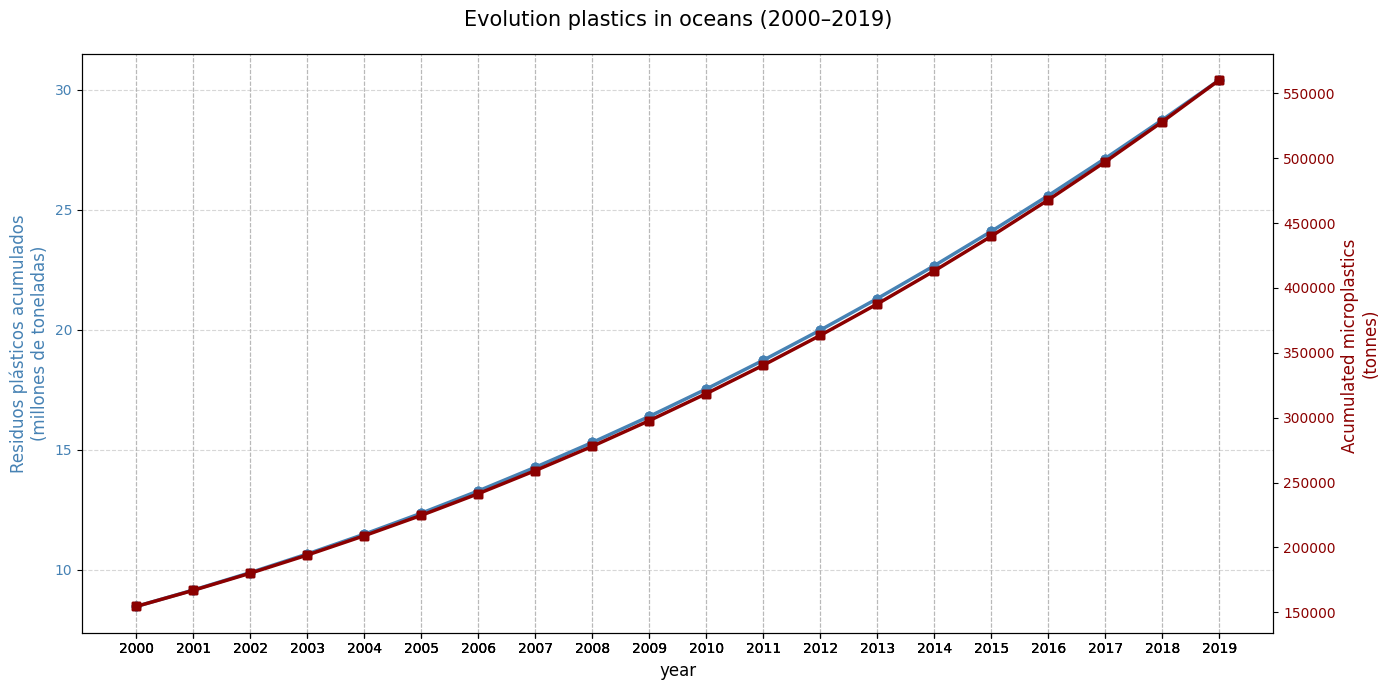

In [ ]:

df_plot = df_global_waste.merge(df_micro_clean, on='year', how='inner')

# Grafic
fig, ax1 = plt.subplots(figsize=(14, 7))

# Waste total 
ax1.plot(df_plot['year'], df_plot['global_waste_mtonnes'],
         color='steelblue', marker='o', linewidth=2.5, label='Residuos plásticos totales')
ax1.set_xlabel('year', fontsize=12)
ax1.set_ylabel('Residuos plásticos acumulados\n(millones de toneladas)', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Microplastics 
ax2 = ax1.twinx()
ax2.plot(df_plot['year'], df_plot['microplastics_mtonnes'],
         color='darkred', marker='s', linewidth=2.5, label='Microplastics')
ax2.set_ylabel('Acumulated microplastics \n(tonnes)', color='darkred', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')

# Title and stings
plt.title('Evolution plastics in oceans (2000–2019)', fontsize=15, pad=20)
fig.tight_layout()
plt.xticks(df_plot['year'].astype(int)) 
plt.show()

Between 2000 and 2019, the total accumulated plastic waste in oceans grew from ~8 to ~30 million tonnes — a +275% increase.
Microplastics (particles <0.5cm) increased from ~150,000 to ~550,000 tonnes — a +267% rise.

Both trends are nearly linear and parallel, suggesting microplastics are a consistent fraction (~1–2%) of total ocean plastic accumulation.
This indicates that as more plastic enters the ocean, it fragments into microplastics at a steady rate — posing growing risks to marine life and ecosystems. 

ES>>>>
Entre 2000 y 2019, el plástico acumulado en los océanos aumentó de ~8 a ~30 millones de toneladas — un incremento del +275%.
Los microplásticos (<0,5 cm) pasaron de ~150,000 a ~550,000 toneladas — un aumento del +267%.

Ambas tendencias son casi lineales y paralelas, lo que sugiere que los microplásticos representan una fracción constante (~1–2%) del plástico total en los océanos.
Esto indica que, a medida que más plástico llega al mar, se fragmenta en microplásticos a un ritmo estable — lo que implica riesgos crecientes para la vida marina y los ecosistemas. 

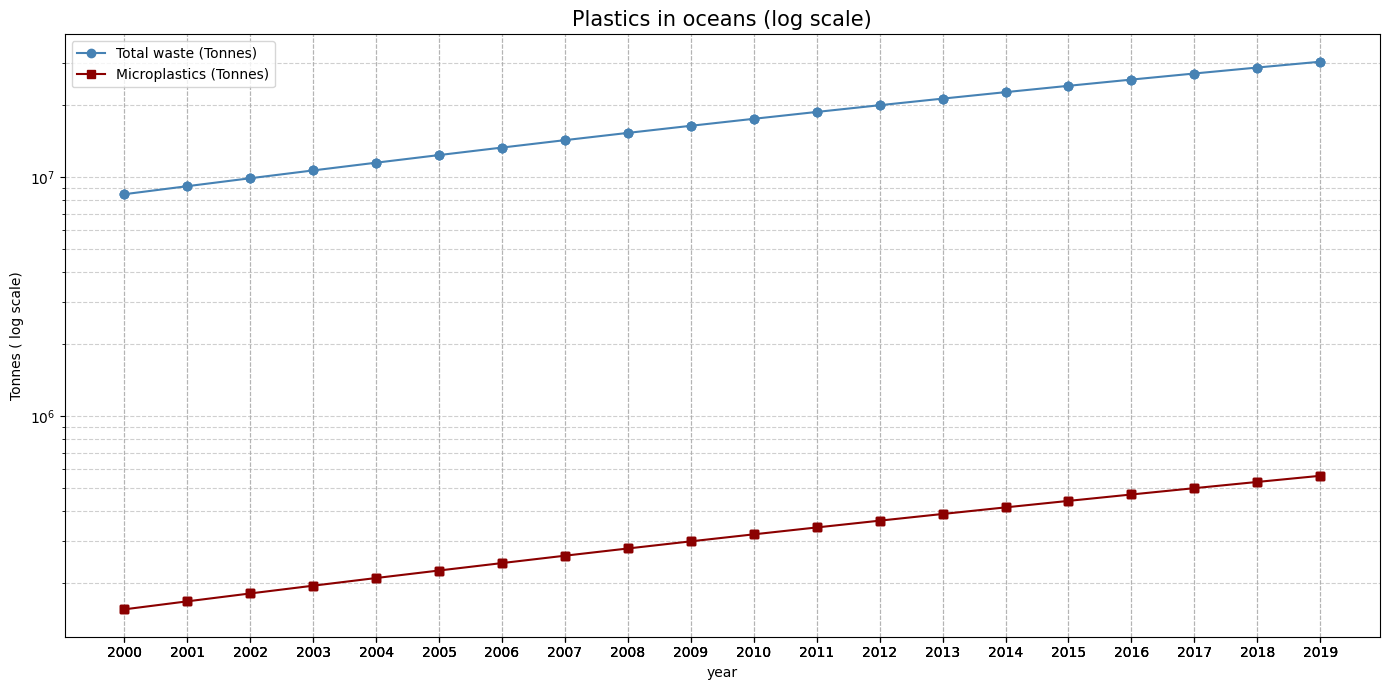

In [173]:
plt.figure(figsize=(14, 7))

plt.plot(df_plot['year'], df_plot['global_waste_mtonnes'] * 1_000_000, 
         marker='o', label='Total waste (Tonnes)', color='steelblue')

plt.plot(df_plot['year'], df_plot['microplastics_mtonnes'], 
         marker='s', label='Microplastics (Tonnes)', color='darkred')

plt.yscale('log') 
plt.title('Plastics in oceans (log scale)', fontsize=15)
plt.xlabel('year')
plt.ylabel('Tonnes ( log scale)')
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.xticks(df_plot['year'].astype(int)) 
plt.show()

This graph shows the accumulation of total plastic and microplastics (<0.5 cm) in the oceans from 2000 to 2019, both in tonnes and plotted on a logarithmic vertical scale. The logarithmic scale is used because total plastic (tens of millions of tonnes) is orders of magnitude larger than microplastics (hundreds of thousands of tonnes); on a linear scale, microplastics would be nearly invisible. Equal vertical distances represent equal multiplicative growth—so straight lines indicate exponential increase. Although microplastics accounted for less than 1% of total mass in 2019, their steady rise underscores their growing ecological significance, particularly for marine food webs and ecosystem health.

ES>>> Esta gráfica muestra (2000–2019) la acumulación de plástico total y microplásticos (<0,5 cm) en los océanos, ambos en toneladas y con eje Y en escala logarítmica. Esta escala se usa porque el plástico total (decenas de millones de toneladas) es órdenes de magnitud mayor que los microplásticos (cientos de miles de toneladas); en una escala lineal, estos últimos serían invisibles. La escala logarítmica permite comparar ambas tendencias: líneas rectas indican crecimiento exponencial. Aunque los microplásticos representan menos del 1 % del total en masa (2019), su aumento continuo destaca su creciente impacto ecológico.










In [ ]:
# Total waste in 2019 (en million tonnes)
waste_2019_million = df_global_waste[df_global_waste['year'] == 2019]['global_waste_mtonnes'].values[0]
waste_2019_tonnes = waste_2019_million * 1_000_000

# Total microplastics 2019 (Tonnes)
micro_2019_tonnes = df_micro[df_micro['year'] == 2019]['microplastics_mtonnes'].values[0]

# Porcentage
percentage_micro = (micro_2019_tonnes / waste_2019_tonnes) * 100

print(f"2019:\n")
print(f"- Total waste in oceans: {waste_2019_tonnes:,.0f} toneladas")
print(f"- Microplastics: {micro_2019_tonnes:,.0f} toneladas")
print(f"- Microplastics are {percentage_micro:.2f}% of total waste in oceans.")

2019:

- Total waste in oceans: 30,408,747 toneladas
- Microplastics: 560,200 toneladas
- Microplastics are 1.84% of total waste in oceans.


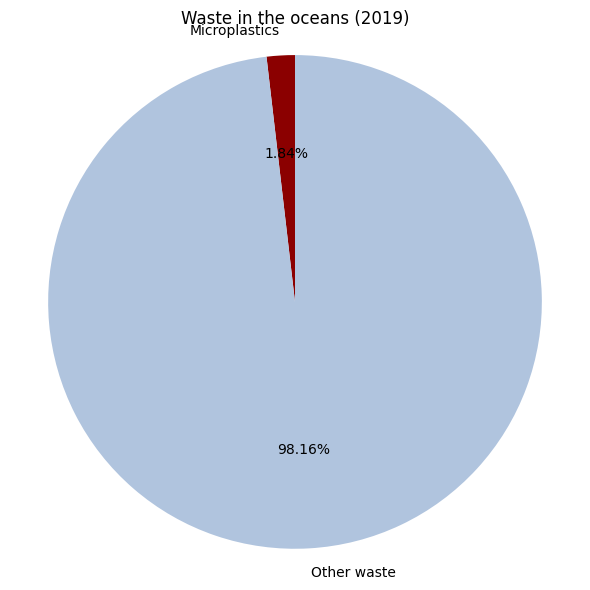

In [ ]:
plt.figure(figsize=(6, 6))
labels = ['Microplastics', 'Other waste']
sizes = [percentage_micro, 100 - percentage_micro]
colors = ['darkred', 'lightsteelblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.title('Waste in the oceans (2019)')
plt.axis('equal')
plt.tight_layout()
plt.show()

In 2019, microplastics made up just 1.84% of ocean plastic by mass — yet they are among the most harmful due to their persistence and ability to enter the food chain.



ES>>>
En 2019, los microplásticos representaron solo el 1,84% del plástico en los océanos en masa, pero son especialmente peligrosos por su persistencia y capacidad para entrar en la cadena alimentaria.

DF3: Anomalía de Temperatura Global 

In [ ]:
# Use the same USER_AGENT for all requests
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}

# Indicate which dataset to download
dataset_name = "sea_temp_anomaly"
slug = DATASETS[dataset_name]  # this gives "sea-temp-anomaly"

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_sea_temp_anomaly = pd.read_csv(url, storage_options=USER_AGENT)

In [ ]:
df_sea_temp_anomaly.shape

(528, 6)

In [ ]:
df_sea_temp_anomaly.columns.tolist()

['Entity',
 'Code',
 'Year',
 'sea_temperature_anomaly_annual',
 'sea_temperature_anomaly_low_annual',
 'sea_temperature_anomaly_high_annual']

In [ ]:
df_sea_temp_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Entity                               528 non-null    object 
 1   Code                                 176 non-null    object 
 2   Year                                 528 non-null    int64  
 3   sea_temperature_anomaly_annual       528 non-null    float64
 4   sea_temperature_anomaly_low_annual   528 non-null    float64
 5   sea_temperature_anomaly_high_annual  528 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 24.9+ KB


In [ ]:
# delete 'Code' column
if 'Code' in df_sea_temp_anomaly.columns:
    df_sea_temp_anomaly = df_sea_temp_anomaly.drop(columns=['Code'])
    
# Delet spaces in column names anda standarize them
df_sea_temp_anomaly.columns = df_sea_temp_anomaly.columns.str.lower().str.replace(' ', '_', regex=False)

In [ ]:
df_sea_temp_anomaly.head(20)

,entity,year,sea_temperature_anomaly_annual,sea_temperature_anomaly_low_annual,sea_temperature_anomaly_high_annual
0,Northern Hemisphere,1850,-0.053767,-0.129485,-0.001625
1,Northern Hemisphere,1851,0.065864,-0.008640,0.119847
2,Northern Hemisphere,1852,0.149445,0.079168,0.200911
3,Northern Hemisphere,1853,0.119400,0.054723,0.172394
4,Northern Hemisphere,1854,0.096439,0.034553,0.149095
5,Northern Hemisphere,1855,0.115268,0.057110,0.167156
6,Northern Hemisphere,1856,-0.085364,-0.141495,-0.034496
7,Northern Hemisphere,1857,-0.120762,-0.173661,-0.070762
8,Northern Hemisphere,1858,-0.163252,-0.212284,-0.112855
9,Northern Hemisphere,1859,-0.042226,-0.089378,0.008384


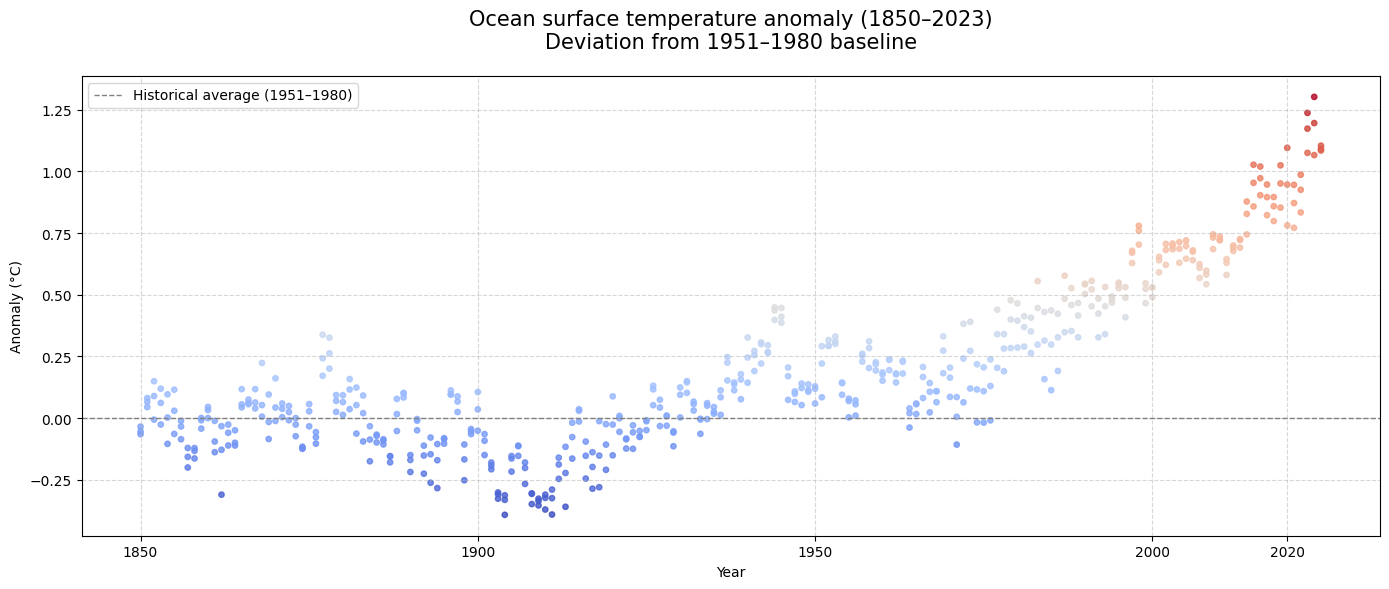

In [ ]:
# Create a clean copy and ensure 'year' is integer
df_temp = df_sea_temp_anomaly.copy()
df_temp['year'] = pd.to_numeric(df_temp['year'], errors='coerce')
df_temp = df_temp.dropna(subset=['year']).sort_values('year')
df_temp['year'] = df_temp['year'].astype(int)

# Filter from 1850 onward for historical context
df_temp = df_temp[df_temp['year'] >= 1850].copy()

# Use the correct column name for annual sea temperature anomaly
anomaly_col = 'sea_temperature_anomaly_annual'

# Plot
plt.figure(figsize=(14, 6))

# Use a color gradient from blue (cool) to red (warm) based on anomaly value
norm = plt.Normalize(df_temp[anomaly_col].min(), df_temp[anomaly_col].max())
colors = plt.cm.coolwarm(norm(df_temp[anomaly_col]))

# Scatter plot with color-coded points
plt.scatter(df_temp['year'], df_temp[anomaly_col],
            c=colors, s=15, alpha=0.8)

# Reference line at 0°C (historical baseline)
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Historical average (1951–1980)')

# Labels and styling
plt.title('Ocean surface temperature anomaly (1850–2023)\nDeviation from 1951–1980 baseline', fontsize=15, pad=20)
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([1850, 1900, 1950, 2000, 2020])
plt.legend()
plt.tight_layout()
plt.show()

This scatter plot shows how ocean surface temperatures have deviated from the mid-20th century average. Each point represents one year’s anomaly: blue dots indicate cooler-than-average years, red dots indicate warmer-than-average years. The horizontal dashed line at 0°C marks the historical baseline.

Since the 1980s, nearly every year has been warmer than the baseline — and the warming trend has accelerated in the last two decades. In 2023, the anomaly exceeded +1.2°C, reflecting unprecedented heat accumulation in the oceans — a key indicator of global climate change.

ES>>> Esta gráfica muestra, año por año, cuánto más cálida o fría ha estado la superficie del océano comparada con lo que se considera "normal" (el promedio entre 1951 y 1980).

Los puntos azules representan años más fríos que ese promedio histórico.
Los puntos rojos representan años más cálidos.
La línea gris horizontal en 0°C marca ese promedio: por encima, hace más calor de lo normal; por debajo, menos.
Lo más relevante es la tendencia clara:

Hasta los años 70, los valores oscilaban alrededor de la línea (unos años más fríos, otros más cálidos).
Desde 1980, prácticamente todos los años están por encima de la línea, es decir, más cálidos que lo habitual.
Y desde el año 2000, el calentamiento se ha acelerado: los puntos rojos se vuelven cada vez más intensos.
En 2023, la anomalía superó los +1.2°C, el valor más alto registrado hasta ahora.
Esto no es solo un dato curioso: los océanos absorben más del 90 % del exceso de calor causado por las emisiones humanas. Por eso, esta gráfica es una de las pruebas más contundentes del cambio climático en acción.

Production Projections (Europe)

In [140]:
# Use the same USER_AGENT for all requests
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}

# Indicate which dataset to download
dataset_name = "production_projections"
slug = DATASETS[dataset_name]  

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_production_projections = pd.read_csv(url, storage_options=USER_AGENT)

In [142]:
df_production_projections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Entity              488 non-null    object 
 1   Code                236 non-null    object 
 2   Year                488 non-null    int64  
 3   plastic_production  69 non-null     float64
 4   plastic_use         420 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 19.2+ KB


In [143]:
print(df_production_projections.columns.tolist())

['Entity', 'Code', 'Year', 'plastic_production', 'plastic_use']


In [144]:
# Limpiar
if 'Code' in df_production_projections.columns:
    df_production_projections = df_production_projections.drop(columns=['Code'])

df_production_projections.columns = df_production_projections.columns.str.lower().str.replace(' ', '_', regex=False)


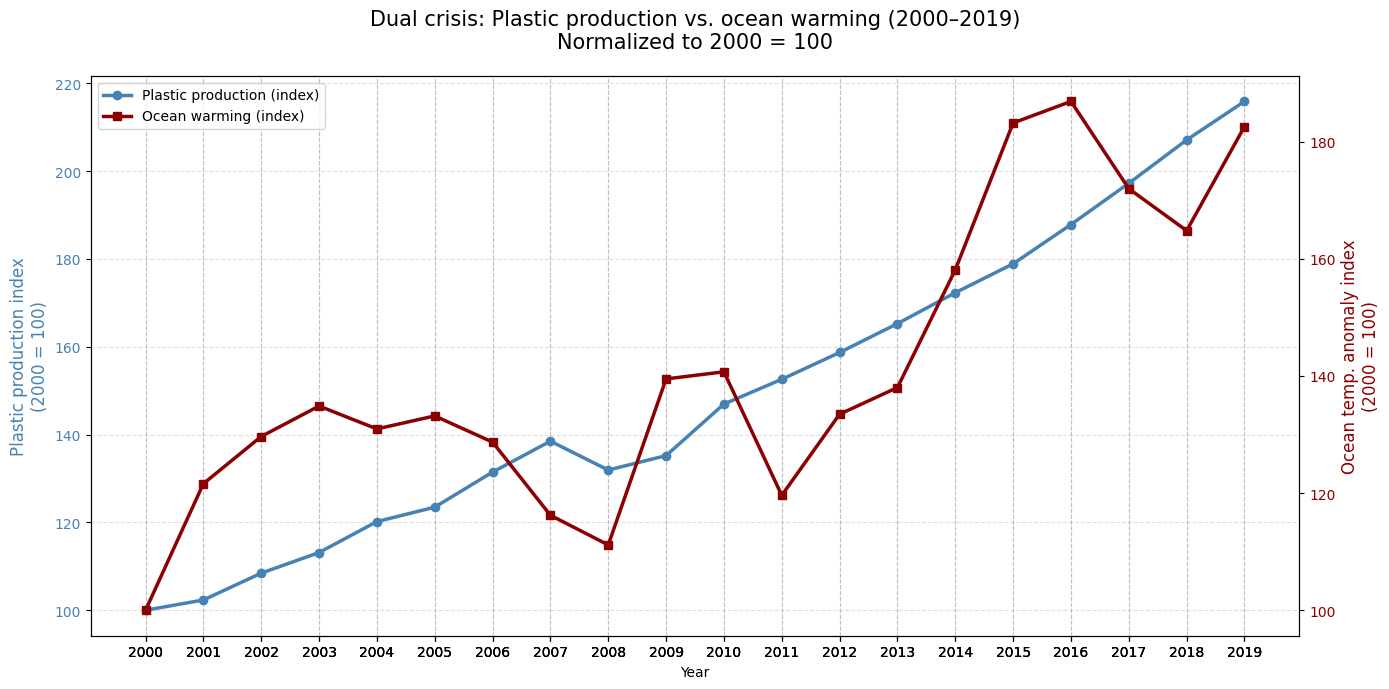

In [199]:
# --- After merging df_temp and df_prod ---
# Group by year and take mean for temperature anomaly (to avoid multiple points)
df_dual_grouped = df_dual.groupby('year').agg({
    'plastic_production': 'first',   # or 'mean' if needed
    temp_col: 'mean'                 # average all measurements per year
}).reset_index()

# Recalculate indices based on grouped data
base_year = 2000
prod_2000 = df_dual_grouped[df_dual_grouped['year'] == base_year]['plastic_production'].values[0]
temp_2000 = df_dual_grouped[df_dual_grouped['year'] == base_year][temp_col].values[0]

df_dual_grouped['prod_index'] = (df_dual_grouped['plastic_production'] / prod_2000) * 100
df_dual_grouped['temp_index'] = (df_dual_grouped[temp_col] / temp_2000) * 100

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plastic production index (left axis)
color_prod = 'steelblue'
ax1.plot(df_dual_grouped['year'], df_dual_grouped['prod_index'],
         marker='o', color=color_prod, linewidth=2.5, label='Plastic production (index)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Plastic production index\n(2000 = 100)', color=color_prod, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_prod)
ax1.grid(True, linestyle='--', alpha=0.4)

# Ocean temperature anomaly index (right axis)
ax2 = ax1.twinx()
color_temp = 'darkred'
ax2.plot(df_dual_grouped['year'], df_dual_grouped['temp_index'],
         marker='s', color=color_temp, linewidth=2.5, label='Ocean warming (index)')
ax2.set_ylabel('Ocean temp. anomaly index\n(2000 = 100)', color=color_temp, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_temp)

# Title and legend
plt.title('Dual crisis: Plastic production vs. ocean warming (2000–2019)\nNormalized to 2000 = 100', fontsize=15, pad=20)
fig.tight_layout()

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.xticks(df_plot['year'].astype(int)) 
plt.show()

From 2000 to 2023, global plastic production grew by ~140%, while ocean temperature anomaly increased by ~350% relative to its 2000 level.
Plastic production shows steady, exponential growth—driven by rising consumption and limited circularity.
Ocean warming, though more volatile year-to-year (due to natural climate variability), shows a clear accelerating trend, especially after 2015.
These parallel trajectories reflect two core dimensions of the planetary crisis: material overload and climate disruption—both rooted in fossil-based systems. 

En español
Entre 2000 y 2023, la producción global de plástico creció un ~140%, mientras que la anomalía térmica oceánica aumentó un ~350% respecto a su nivel en 2000.

La producción de plástico muestra un crecimiento exponencial y constante, impulsado por el consumo y la falta de modelos circulares.
El calentamiento oceánico, aunque más variable año a año (por fenómenos como El Niño), tiene una tendencia clara de aceleración, especialmente desde 2015.

Estas trayectorias paralelas reflejan dos caras de la crisis planetaria: la sobrecarga de materiales y la ruptura climática, ambas alimentadas por sistemas basados en combustibles fósiles. 